In [ ]:
import sys
from pyspark import SparkContext, SparkConf
import time
from pyspark.sql import functions as F
from pyspark.sql import SQLContext
import matplotlib.pyplot as plt

# start spark with 1 worker thread
sc = SparkContext("local[8]")
sc.setLogLevel("ERROR")
sqlContext = SQLContext(sc)

print("OK")



=== Priority-Based Scheduling Delay Analysis ===

Sample of task delays:
+----------+----------+---------------+------------------+------------+
|    job_id|task_index|submit_priority|submit_sched_class|waiting_time|
+----------+----------+---------------+------------------+------------+
|6336594489|      3929|              0|                 0|  7513261454|
|6336594489|      3929|              0|                 0|  5681508581|
|6336594489|      3929|              0|                 0|  3848681242|
|6336594489|      3929|              0|                 0|  2365916885|
|6336594489|      3929|              0|                 0|   521438510|
|6336594489|      3929|              0|                 0|     1493677|
|6336594489|      2156|              0|                 0|  7111547848|
|6336594489|      2156|              0|                 0|  5281237168|
|6336594489|      2156|              0|                 0|  3449053780|
|6336594489|      2156|              0|                 0|  18

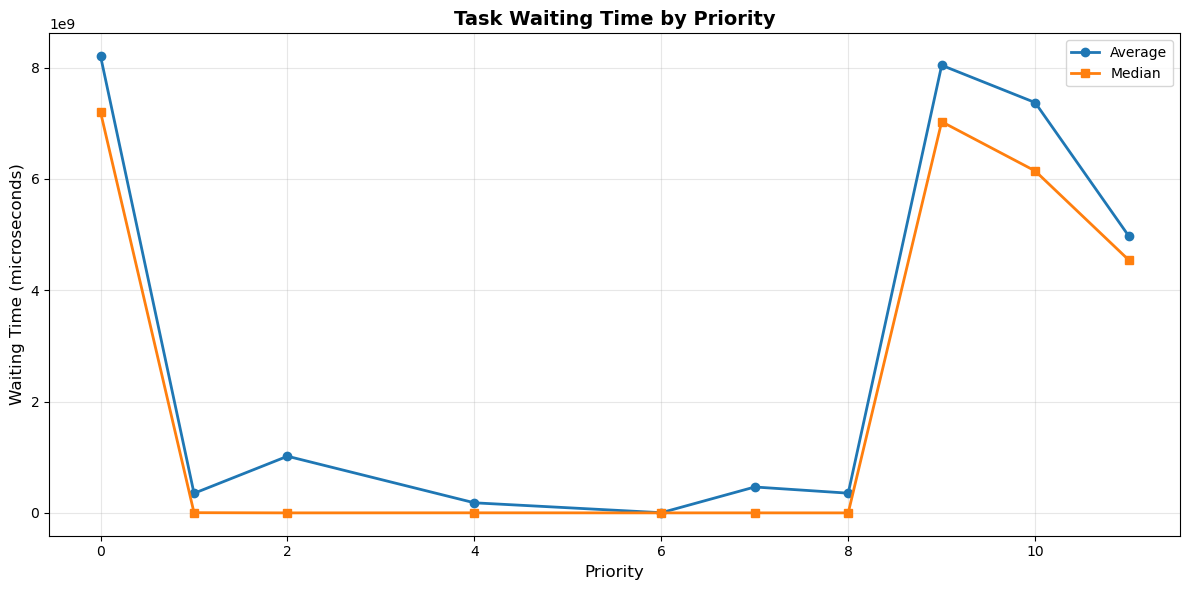

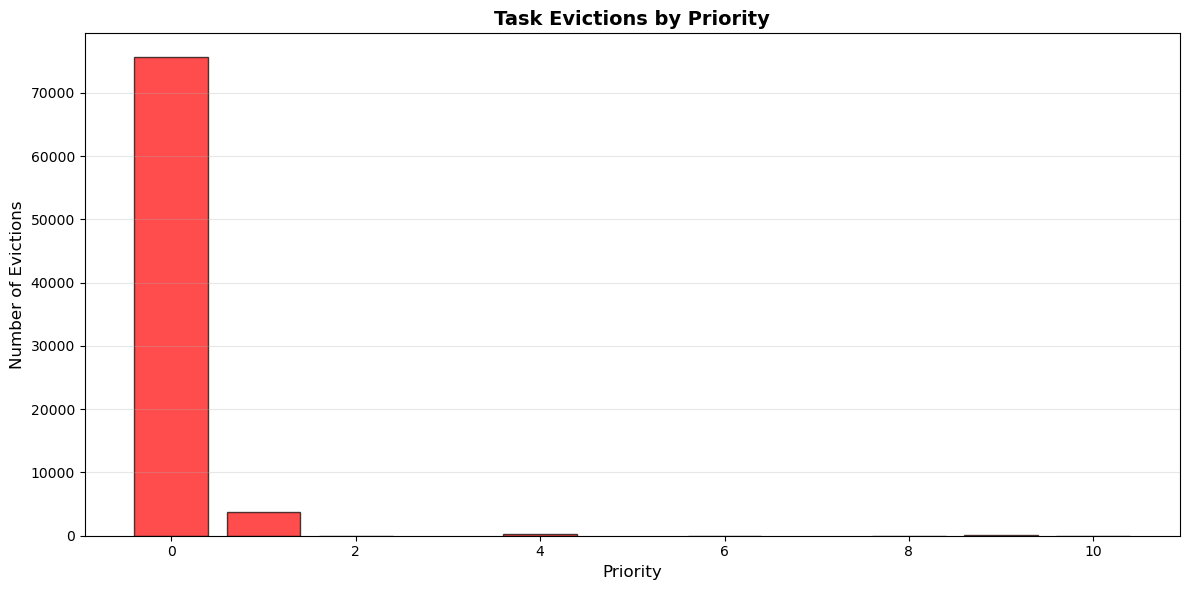


✓ Analysis complete. Visualizations saved.


In [5]:


task_events_paths = [
    "google-dataset/task_events/part-00265-of-00500.csv.gz",
    "google-dataset/task_events/part-00266-of-00500.csv.gz",
    "google-dataset/task_events/part-00267-of-00500.csv.gz",
    "google-dataset/task_events/part-00268-of-00500.csv.gz",
    "google-dataset/task_events/part-00269-of-00500.csv.gz",
]

# Schema: _c0=time, _c2=job_id, _c3=task_index, _c4=machine_id, _c5=event_type, _c6=user, _c7=scheduling_class, _c8=priority
te = sqlContext.read.csv(task_events_paths, header=False, inferSchema=True) \
    .withColumnRenamed("_c0", "time") \
    .withColumnRenamed("_c2", "job_id") \
    .withColumnRenamed("_c3", "task_index") \
    .withColumnRenamed("_c4", "machine_id") \
    .withColumnRenamed("_c5", "event_type") \
    .withColumnRenamed("_c7", "scheduling_class") \
    .withColumnRenamed("_c8", "priority")

# Event types: 0=SUBMIT, 1=SCHEDULE, 2=EVICT, 3=FAIL, 4=FINISH, 5=KILL, 6=LOST
SUBMIT = 0
SCHEDULE = 1
EVICT = 2
print("\n=== Priority-Based Scheduling Delay Analysis ===")

# 1. Calculate waiting time: time between SUBMIT and SCHEDULE
submit_events = te.filter(F.col("event_type") == SUBMIT) \
    .select("job_id", "task_index", "time", "priority", "scheduling_class", "machine_id") \
    .withColumnRenamed("time", "submit_time") \
    .withColumnRenamed("priority", "submit_priority") \
    .withColumnRenamed("scheduling_class", "submit_sched_class")

schedule_events = te.filter(F.col("event_type") == SCHEDULE) \
    .select("job_id", "task_index", "time", "machine_id") \
    .withColumnRenamed("time", "schedule_time") \
    .withColumnRenamed("machine_id", "schedule_machine_id")

# Join to get waiting time per task
task_delays = submit_events.join(
    schedule_events,
    on=["job_id", "task_index"],
    how="inner").withColumn(
    "waiting_time",
    F.col("schedule_time") - F.col("submit_time")
).filter(F.col("waiting_time") >= 0)  # Nur gültige Wartezeiten
print("\nSample of task delays:")
task_delays.select("job_id", "task_index", "submit_priority", "submit_sched_class", "waiting_time").show(10)

# 2. Aggregate by priority
priority_stats = task_delays.groupBy("submit_priority").agg(
    F.count("*").alias("num_tasks"),
    F.avg("waiting_time").alias("avg_waiting_time"),
    F.min("waiting_time").alias("min_waiting_time"),
    F.max("waiting_time").alias("max_waiting_time"),
    F.expr("percentile_approx(waiting_time, 0.5)").alias("median_waiting_time"),
    F.expr("percentile_approx(waiting_time, 0.95)").alias("p95_waiting_time")
).orderBy("submit_priority")

print("\n=== Waiting Time by Priority ===")
priority_stats.show(20, truncate=False)

# 3. Aggregate by scheduling class
sched_class_stats = task_delays.groupBy("submit_sched_class").agg(
    F.count("*").alias("num_tasks"),
    F.avg("waiting_time").alias("avg_waiting_time"),
    F.expr("percentile_approx(waiting_time, 0.5)").alias("median_waiting_time"),
    F.expr("percentile_approx(waiting_time, 0.95)").alias("p95_waiting_time")
).orderBy("submit_sched_class")

print("\n=== Waiting Time by Scheduling Class ===")
sched_class_stats.show(20, truncate=False)

# 4. Analyze evictions by priority
evict_events = te.filter(F.col("event_type") == EVICT) \
    .select("job_id", "task_index", "priority") \
    .withColumnRenamed("priority", "evict_priority")

eviction_by_priority = evict_events.groupBy("evict_priority").agg(
    F.count("*").alias("num_evictions")
).orderBy("evict_priority")

print("\n=== Evictions by Priority ===")
eviction_by_priority.show(20, truncate=False)

# 5. Machine contention analysis: concurrent tasks on same machine
machine_tasks = te.filter(F.col("event_type") == SCHEDULE) \
    .select("time", "machine_id", "job_id", "task_index", "priority") \
    .dropna(subset=["machine_id", "priority"])

# Approximation: count tasks scheduled on same machine in time windows
machine_priority_mix = machine_tasks.groupBy("machine_id").agg(
    F.countDistinct("priority").alias("num_different_priorities"),
    F.min("priority").alias("min_priority"),
    F.max("priority").alias("max_priority")
)

priority_contention = machine_priority_mix.groupBy("num_different_priorities").agg(
    F.count("*").alias("num_machines")
).orderBy("num_different_priorities")

print("\n=== Priority Contention on Machines ===")
print("Number of different priorities per machine:")
priority_contention.show(20, truncate=False)

##%%### Visualizations# 1. Average waiting time by priority
priority_data = priority_stats.collect()
priorities = [row['submit_priority'] for row in priority_data if row['submit_priority'] is not None]
avg_waiting = [row['avg_waiting_time'] for row in priority_data if row['submit_priority'] is not None]
median_waiting = [row['median_waiting_time'] for row in priority_data if row['submit_priority'] is not None]

plt.figure(figsize=(12, 6))
plt.plot(priorities, avg_waiting, marker='o', label='Average', linewidth=2)
plt.plot(priorities, median_waiting, marker='s', label='Median', linewidth=2)
plt.xlabel('Priority', fontsize=12)
plt.ylabel('Waiting Time (microseconds)', fontsize=12)
plt.title('Task Waiting Time by Priority', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('waiting_time_by_priority.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Evictions by priority
eviction_data = eviction_by_priority.collect()
evict_priorities = [row['evict_priority'] for row in eviction_data if row['evict_priority'] is not None]
evict_counts = [row['num_evictions'] for row in eviction_data if row['evict_priority'] is not None]

plt.figure(figsize=(12, 6))
plt.bar(evict_priorities, evict_counts, color='red', alpha=0.7, edgecolor='black')
plt.xlabel('Priority', fontsize=12)
plt.ylabel('Number of Evictions', fontsize=12)
plt.title('Task Evictions by Priority', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('evictions_by_priority.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Analysis complete. visualizations saved.")
